# Document Significance

DS 5001 Text as Data

# Overview

Three kinds of signficance relative to a corpus $C$:

* __Local__: `TF-IDF` (significance of a term in a document; related to $p(w|d, C)$ ).
* __Global__: Aggregate `TF-IDF` by term or `DH` (significance of a term in the corpus by document; related to $p( w|C_d ) $ ).
* __Document__: Aggreate `TF-IDF` by document (significance of document in the corpus; related to $p(d|W_d,C) $ ).

Context matters for document signficance, e.g. chapter significance should be computed within the context of the novel, not the corpus.

# Set Up

In [1]:
import pandas as pd
import numpy as np
import plotly_express as px
import plotly.graph_objects as go # For more control on graphs
import re

In [2]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home'] 
output_dir = config['DEFAULT']['output_dir']
data_prefix = 'austen-melville'

In [8]:
OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']
bags = dict(
    SENTS = OHCO[:4],
    PARAS = OHCO[:3],
    CHAPS = OHCO[:2],
    BOOKS = OHCO[:1]
)

In [9]:
bag = 'CHAPS'

# Get Data

In [11]:
LIB = pd.read_csv(f"{output_dir}/{data_prefix}-LIB.csv").set_index('book_id')
DTCM = pd.read_csv(f'{output_dir}/{data_prefix}-DTCM-{bag}.csv').set_index(bags[bag]) 
TFIDF = pd.read_csv(f'{output_dir}/{data_prefix}-TFIDF-{bag}.csv').set_index(bags[bag])

# Document Significance

This is an experimental concept that focuses on the amount of significance contained in a document, such as a book chapter, based on aggregate TFIDF of terms in a book.

Here we recompute TFIDF based on boolean counts for `TF`, since `DH` is the same as mean `TFIDF` for boolean counts. 

In [72]:
BOOL = DTCM.astype('bool')
DF = BOOL.sum()
TF = (BOOL.T / BOOL.T.sum()).T
IDF = np.log2(len(TF)/DF)
BOOL_TFIDF = TF * IDF

We create a DOC table to store info about each bag.

In [73]:
DOC = pd.DataFrame(index=DTCM.index)
DOC['book_chap_sig_bool'] = BOOL_TFIDF.T.mean()
DOC['book_chap_sig'] = TFIDF.T.mean()
DOC['n_tokens'] = DTCM.sum(1)

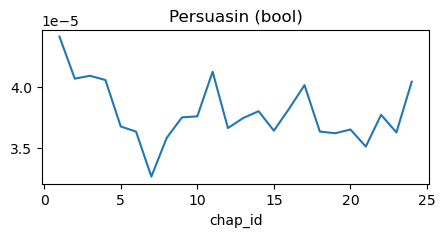

In [74]:
DOC.loc[105].book_chap_sig.plot.line(figsize=(5,2), title="Persuasin (bool)");

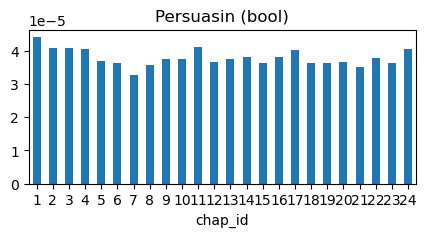

In [75]:
DOC.loc[105].book_chap_sig.plot.bar(figsize=(5,2), title="Persuasin (bool)", rot=0);

Define function to visualize chapter significance over narrative time.

In [76]:
def plot_sig_docs2(book_id, type='scatter', use_bool=True):

    global DOC
    
    sig_col = "book_chap_sig" + "_bool" * use_bool
    print(sig_col)
    
    D = DOC.loc[book_id]
    title = LIB.loc[book_id].title
    point_size = (D.n_tokens / D.n_tokens.sum()) * 700
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=D.index, y=D[sig_col], 
                             text=D.index, 
                             mode = 'lines+markers+text',
                             marker = dict(size=point_size, color='#BBB'),
                             line = dict(color='#DADADA'),
                             textfont = dict(color="black")
                            ))
                  
    fig.update_layout(
        font = dict(color="#000", size=14),
        title=title,
        xaxis_title="Chapter",
        yaxis_title="Significance",
        height=800
    )
    fig.show()

Also define function to see how length and significance are related.

In [77]:
def plot_n_sig(book_id, use_bool=True):
    sig_col = "book_chap_sig" + "_bool" * use_bool
    ax = DOC.loc[book_id].plot.scatter('n_tokens', sig_col, title=f"{LIB.loc[book_id, 'title']}");
    DOC.loc[book_id].apply(lambda row: ax.text(row.n_tokens, row[sig_col], f"  {row.name}"), axis=1)

book_chap_sig_bool


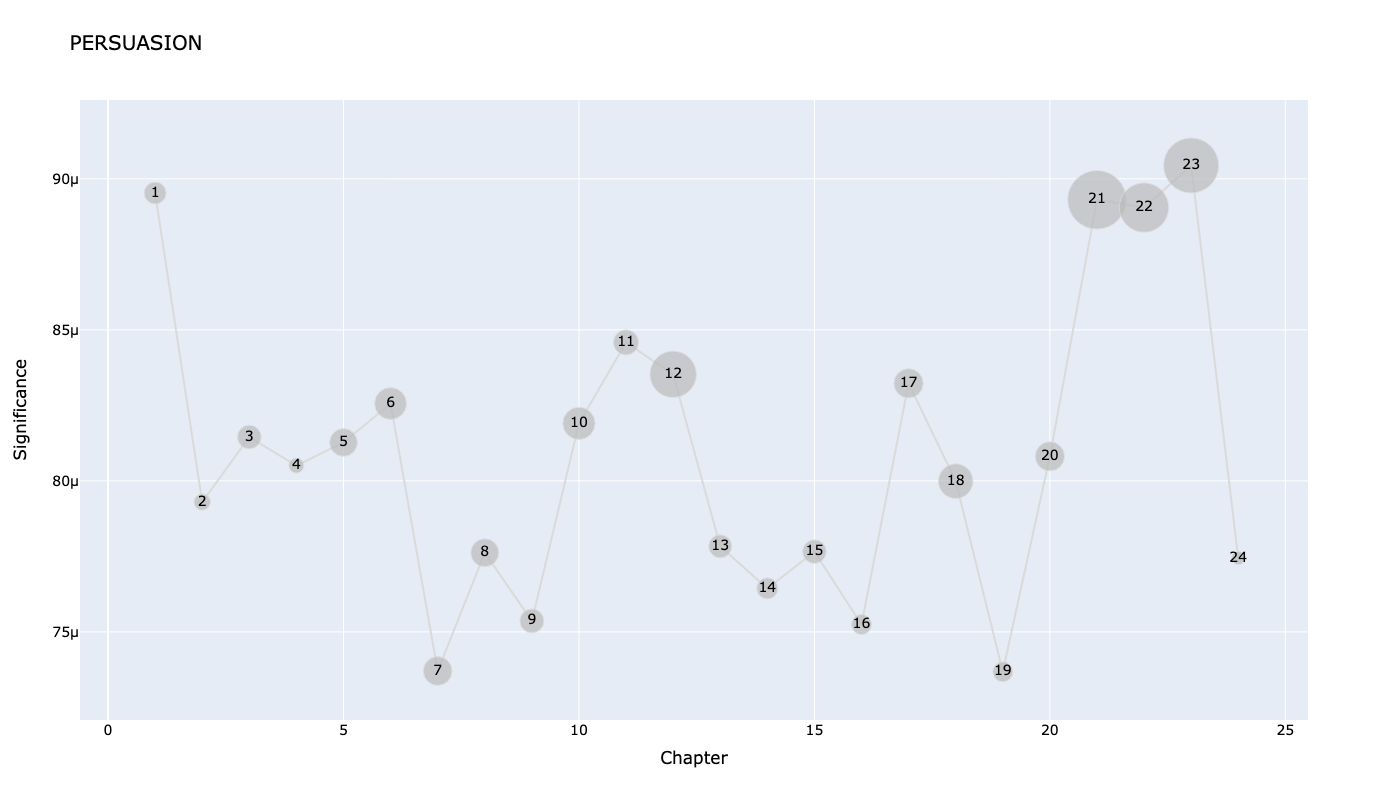

In [78]:
plot_sig_docs2(105)
# plot_sig_docs2(105, use_bool=False)

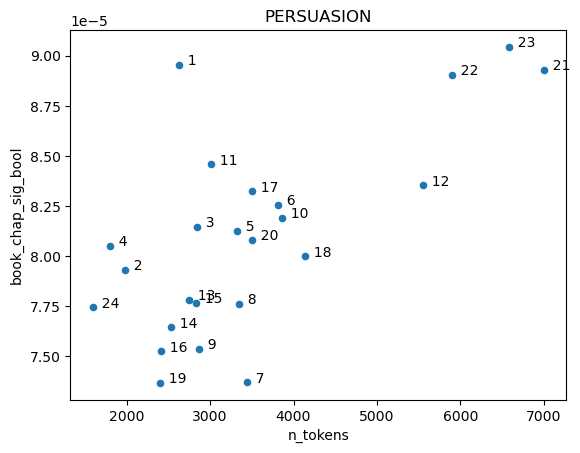

In [80]:
plot_n_sig(105);
# plot_n_sig(105, False);

> **Chapter 12 signals a climax in the novel's narrative.** Persuasion is a linear narrative that is organized chronologically. The original edition of this novel was published in two volumes, **the first volume ending at the close of Chapter 12**. Louisa's fall is the greatest dramatic occurrence which has happened so far. By inserting the fall here, Austen creates a cliffhanger and encourages her readers to buy the second volume of her novel. In these chapters, the reader is shown the negative effects of what can happen when one is too stubborn. Louisa would not be persuaded to keep from jumping off the wall. Her firmness of mind means serious injury for her and significant guilt for Captain Wentworth. He is encouraged to rethink his initial judgment of the benefit of a "strong character." [Sparknotes](https://www.sparknotes.com/lit/persuasion/section6/page/2/)

book_chap_sig_bool


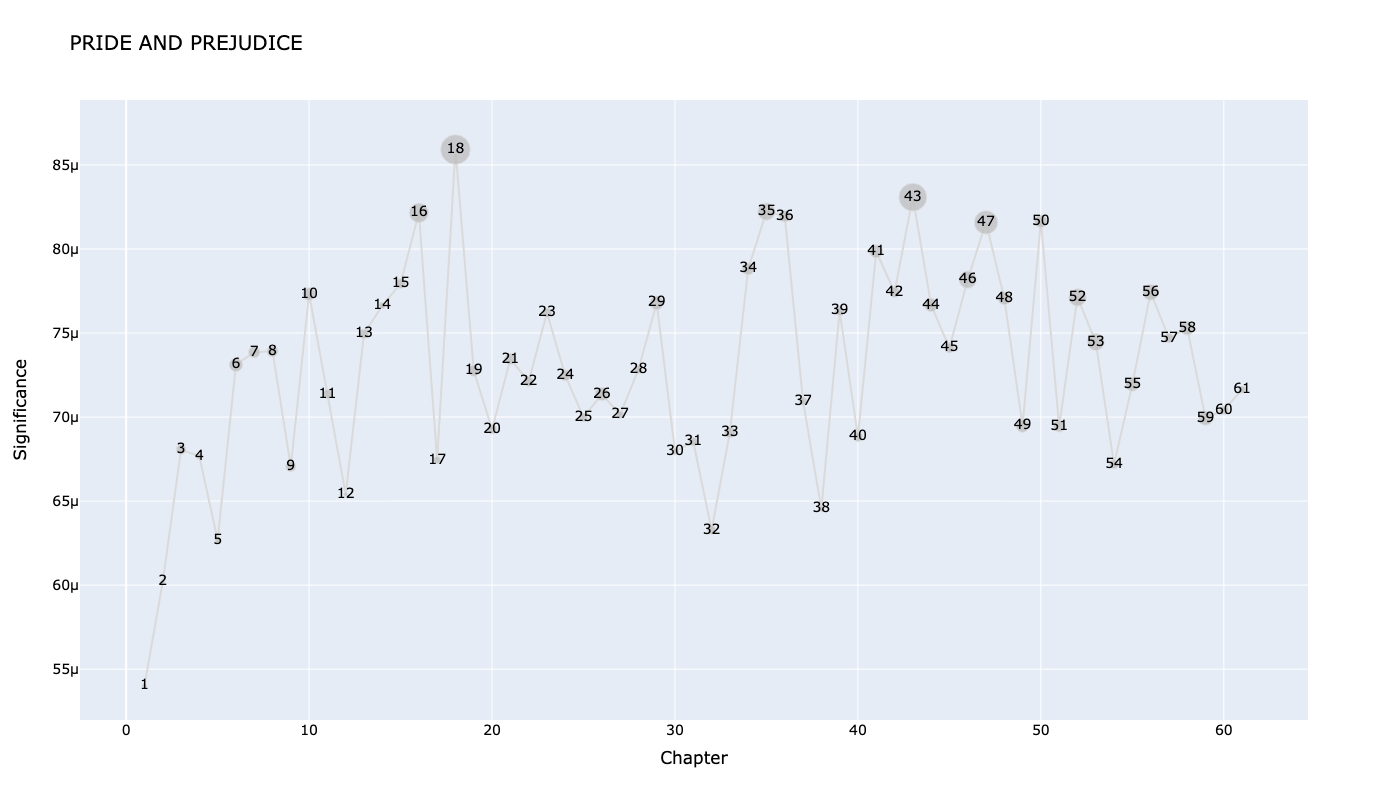

In [81]:
plot_sig_docs2(1342)

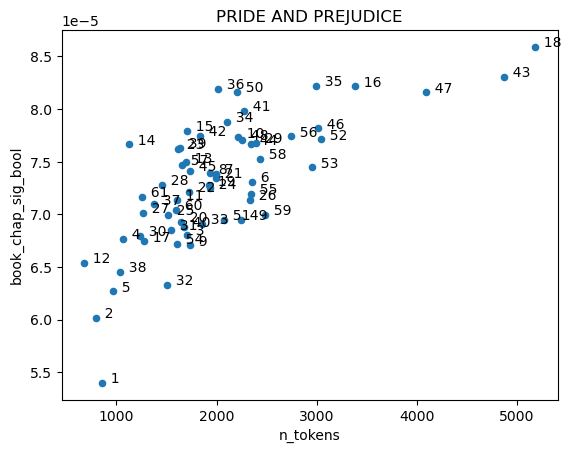

In [82]:
plot_n_sig(1342)

book_chap_sig_bool


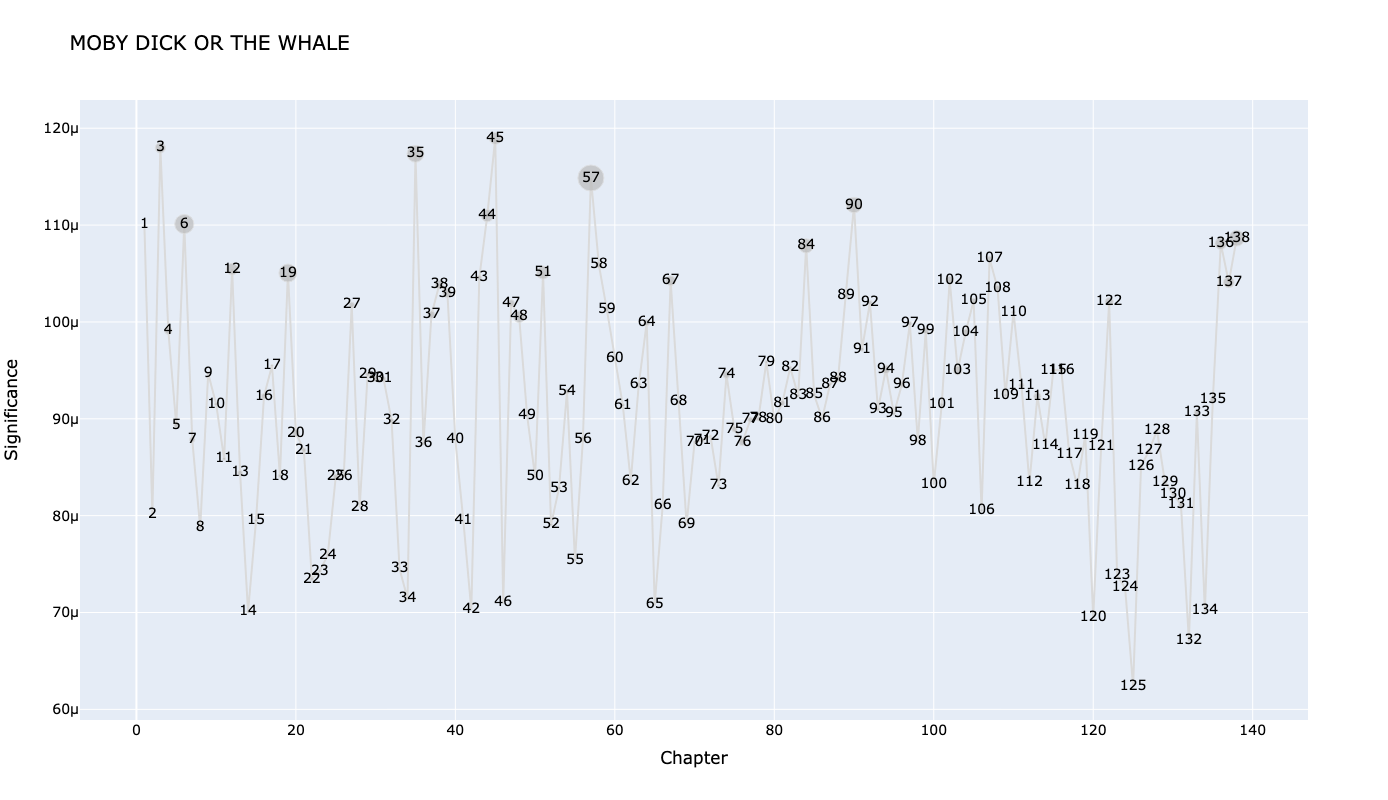

In [83]:
plot_sig_docs2(2701)

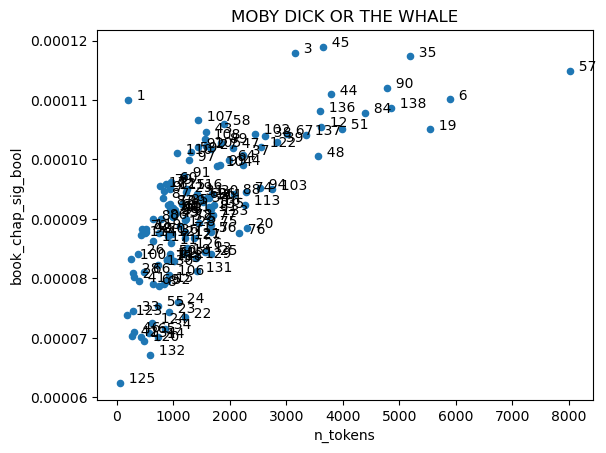

In [84]:
plot_n_sig(2701)